<a href="https://colab.research.google.com/github/awais546/Intelligent-Cyber-Secuirty/blob/master/Membership_Attack_annotated_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = 'content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root=project_path+'/data', train=False,
                                       download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 


Files already downloaded and verified
Files already downloaded and verified


truck plane  frog  bird


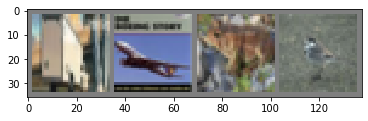

In [14]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images


In [15]:
# divide the training dataset into the required groups Make sure they are balanced

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 64

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) output of fc is 10 cuz we have 10 classes!



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels = 3, output channels=6, kernel_size =5 
        self.pool = nn.MaxPool2d(2, 2)  # kernel size = 2, stride = 2
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# initalize a target model and train it

target_model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(target_model.parameters(), lr=0.01)

# let the magic begin
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = target_model(inputs) # make a prediction: forward prop
        
        loss = criterion(outputs, labels) # calculate the loss
        
        loss.backward() # calculate gradients
        
        optimizer.step() # updaate weights in backprop

        # print statistics
        running_loss += loss.item()
       
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training the Target model')

Finished Training the Target model


In [19]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        images, labels = data
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 13 %


In [0]:
shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.SGD(shadow_model.parameters(), lr=0.0001)

# let the magic begin

shadow_running_loss = 0.0


# get the inputs; data is a list of [inputs, labels]
inputs, labels = next(iter(shadow_train_loader))

# zero the parameter gradients
optimizer.zero_grad()

# forward + backward + optimize
outputs = shadow_model(inputs)

In [15]:
print(outputs.shape)
print(labels.shape)


torch.Size([64, 10])
torch.Size([64])




---



In [43]:
# initalize a Shadow Model and Train it
# for the first ICP trail use the same CNN architecture and hyperparameters

shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.SGD(shadow_model.parameters(), lr=0.0001)

# let the magic begin
for epoch in range(20):  # loop over the dataset multiple times

    shadow_running_loss = 0.0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = shadow_model(inputs) # make a prediction: forward prop
        
        shadow_loss = shadow_criterion(outputs, labels) # calculate the loss
        
        shadow_loss.backward # calculate gradients
        
        shadow_optimizer.step() # updaate weights in backprop

        # print statistics
        shadow_running_loss += shadow_loss.item()
       
    print(shadow_running_loss / len(shadow_train_loader))
    shadow_running_loss = 0.0

print('Finished Training the Shadow model')

2.30525280018242
2.3052362021134822
2.3052425542656256
2.3051964506811027
2.305379655896401
2.305260993996445
2.3053575669016158
2.3052587898410097
2.305235323857288
2.30527040301537
2.3052659119878496
2.3052732117322026
2.3053241615392723
2.3052389646063047
2.305254109051763
2.305341189004937
2.3052948603824692
2.305239582548336
2.3052076113467312
2.305237761565617
Finished Training the Shadow model


In [0]:
inputs = ''
labels = ''
for i, data in enumerate(shadow_train_loader, 0):
  inputss, label = data
  break

In [17]:
inputs[0].shape

torch.Size([3, 32, 32])

In [0]:
# freeze the Shadow model 
# make predictions on both datasets (shadow_in and shdow_out)
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together

new_dataset = []
for i, data in enumerate(shadow_train_loader, 0):
  # get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
  temp = []
  # forward + backward + optimize
  outputs = shadow_model(inputs) # make a prediction: forward prop
  temp = [[e,1] for e in outputs]
  for each in temp:
    new_dataset.append(each)



In [0]:
for i, data in enumerate(shadow_out_loader, 0):
  # get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
  temp = []
  # forward + backward + optimize
  outputs = shadow_model(inputs) # make a prediction: forward prop
  temp = [[e,0] for e in outputs]
  for each in temp:
    new_dataset.append(each)

In [0]:
class attack_Net(nn.Module):
    def __init__(self):
        super().__init__()       
        self.hidden = nn.Linear(10, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 2)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [0]:
import random
random.shuffle(new_dataset)

In [0]:
new_dataset_test = new_dataset[:15000]
new_dataset_train = new_dataset[15000:]


In [0]:
attack_trainloader = torch.utils.data.DataLoader(new_dataset_test, batch_size=64, shuffle=True)

In [0]:
data,labels = next(iter(attack_trainloader))
# print(data.shape)
# print(inputs.shape)
# print(label.shape)
# print(labels.shape)


In [32]:
data.shape

torch.Size([64, 10])

In [0]:
# create the Attack Model
# A NN binary classifier {0, 1}
# the input is a propability distribution and the output is 0 (out) or 1 (in in the training data)



attack_model = attack_Net()
attack_criterion = nn.CrossEntropyLoss()
attack_optimizer = optim.SGD(attack_model.parameters(), lr=0.0001)




In [35]:
attack_loss 

tensor(0.7160, grad_fn=<NllLossBackward>)

In [0]:
inputs,labels = next(iter(attack_trainloader))
attack_optimizer.zero_grad()
outputs = attack_model(inputs)
attack_loss = attack_criterion(outputs, labels)


In [39]:
attack_loss.backward

<bound method Tensor.backward of tensor(0.6847, grad_fn=<NllLossBackward>)>

In [47]:
# let the magic begin

for epoch in range(60):  # loop over the dataset multiple times

    attack_running_loss = 0.0
    
    for i, data in enumerate(attack_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        attack_optimizer.zero_grad()
      
        # forward + backward + optimize
        outputs = attack_model(inputs) # make a prediction: forward prop
        loss = attack_criterion(outputs, labels) # calculate the loss
        
        loss.backward # calculate gradients
        
        
        attack_optimizer.step() # updaate weights in backprop

        # print statistics
        attack_running_loss += loss.item()
       
    print(attack_running_loss / len(new_dataset_train))
    attack_running_loss = 0.0

0.016487046897411345
0.01648773639202118
0.01648845656514168
0.016484925359487534
0.016490933442115784
0.01648648697733879
0.016489733159542084
0.0164887145280838
0.016490404307842255
0.016486856919527053
0.016486959367990495
0.016487771570682527
0.01648732855916023
0.016488225400447844
0.016487630140781404
0.016487243795394898
0.0164856147646904
0.01648457322716713
0.016482829511165618
0.016486203861236573
0.016486893892288208
0.016488333708047868
0.01648681117296219
0.016489932876825333
0.01648698566555977
0.01648803580403328
0.016488836270570757
0.016489018243551253
0.016487020510435105
0.0164882051885128
0.01648566796183586
0.016487164586782455
0.01648633741736412
0.016491242581605912
0.016486447167396546
0.016487557470798494
0.016486964893341064
0.016487406772375108
0.0164871329665184
0.016489304357767104
0.016489972126483916
0.016485809314250945
0.016485335958004
0.016485281985998152
0.016487143886089326
0.01648932799100876
0.016488327276706696
0.016486433947086335
0.016488023996

In [0]:
attack_testloader = torch.utils.data.DataLoader(new_dataset_train, batch_size=64, shuffle=True)
test_input,test_label = next(iter(attack_testloader))

In [0]:
test_output = attack_model(test_input)

In [72]:
test_output.argmax(dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [73]:
test_label

tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0])

In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluare the attack model


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?